In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import torch, torch.nn as nn
import torchvision

from copy import copy
from IPython import display
from IPython.display import clear_output
from PIL import Image
from skimage import color, transform
from sklearn.metrics import roc_auc_score
from time import time, sleep
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

In [2]:
device = 'cpu'

In [3]:
fmnist_train_set = torchvision.datasets.FashionMNIST("./data_fmnist", download=True,
                                                     transform=transforms.Compose([transforms.ToTensor()]))
fmnist_test_set = torchvision.datasets.FashionMNIST("./data_fmnist", download=True, train=False,
                                                    transform=transforms.Compose([transforms.ToTensor()]))
fmnist_train_data = DataLoader(fmnist_train_set, batch_size=32)
fmnist_test_data = DataLoader(fmnist_test_set, batch_size=32)

In [4]:
mnist_train_set = torchvision.datasets.MNIST("./data_mnist", download=True,
                                             transform=transforms.Compose([transforms.ToTensor()]))
mnist_test_set = torchvision.datasets.MNIST("./data_mnist", download=True, train=False,
                                            transform=transforms.Compose([transforms.ToTensor()]))
mnist_train_data = DataLoader(mnist_train_set, batch_size=32)
mnist_test_data = DataLoader(mnist_test_set, batch_size=32)

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.block_1_conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.block_1_relu = nn.ReLU()
        self.block_1_max_pool = nn.MaxPool2d(kernel_size=2)

        self.block_2_conv = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3)
        self.block_2_relu = nn.ReLU()
        self.block_2_max_pool = nn.MaxPool2d(kernel_size=2)
        self.block_2_batch_norm = nn.BatchNorm2d(num_features=16)

        self.block_3_flatten = nn.Flatten()
        self.block_3_linear = nn.Linear(in_features=400, out_features=100)
        self.block_3_relu = nn.ReLU()

        self.block_4_linear = nn.Linear(in_features=100, out_features=10)
        self.block_4_log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.block_1_conv(x)
        x = self.block_1_relu(x)
        x = self.block_1_max_pool(x)

        x = self.block_2_conv(x)
        x = self.block_2_relu(x)
        x = self.block_2_max_pool(x)
        x = self.block_2_batch_norm(x)

        x = self.block_3_flatten(x)
        x = self.block_3_linear(x)
        x = self.block_3_relu(x)

        x = self.block_4_linear(x)
        x = self.block_4_log_softmax(x)
        return x

In [6]:
def validate(teacher, student, data):
    teacher.eval()
    student.eval()
    total_img = 0
    loss = 0
    for images, _ in tqdm(data):
        with torch.no_grad():
            # Transfering images and labels to GPU if available
            images = images.to(device)
            images = images.view(-1, 1, 28, 28)
            total_img += len(images)
            # Forward pass
            with torch.no_grad():
                teacher_pred = teacher(images)
            student_pred = student(images)
            loss += reverse_kl(teacher_pred, student_pred).item()
    return round(loss / total_img, 5)

In [7]:
def plot_results(train_log, val_log, test_log):
    clear_output(wait=True)
    print("Epoch", len(train_log))
    print("Train loss:\t", train_log[-1])
    print("Val loss:\t", val_log[-1])
    print("Test loss:\t", test_log[-1])

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(train_log, label='train loss', c='b')
    ax1.plot(val_log, label='val loss', c='r')
    ax1.grid()
    ax1.legend(loc='best')

    ax2.plot(test_log, label='test_loss', c='g')
    ax2.legend(loc='best')
    ax2.grid()
    plt.show()

In [8]:
def cross_entroy_with_logits(teacher_pred, student_pred):
    return -torch.sum(torch.exp(teacher_pred) * student_pred, dim=1).mean()

In [9]:
def forward_kl(teacher_pred, student_pred):
    return torch.sum(torch.exp(teacher_pred) * (teacher_pred - student_pred))

In [10]:
def reverse_kl(teacher_pred, student_pred):
    return torch.sum(torch.exp(student_pred) * (student_pred - teacher_pred))

In [11]:
def symmetrized_kl(teacher_pred, student_pred):
    return forward_kl(student_pred, teacher_pred) + revrse_kl(student_pred, teacher_pred)

In [12]:
def train(teacher, student, optimizer, train_log, val_log, test_log, num_epochs=30, batch_size=32):
    for epoch in range(num_epochs):
        teacher.train()
        student.train()
        for images, _ in tqdm(mnist_train_data):
            # Transfering images and labels to GPU if available
            images = images.view(-1, 1, 28, 28).to(device)
            # Forward pass
            with torch.no_grad():
                teacher_pred = teacher(images)
            student_pred = student(images)
            loss = reverse_kl(student_pred, teacher_pred)
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_log.append(validate(teacher, student, mnist_train_data))
        val_log.append(validate(teacher, student, mnist_test_data))
        test_log.append(validate(teacher, student, fmnist_train_data))
        plot_results(train_log, val_log, test_log)

In [13]:
train_log = []
val_log = []
test_log = []

In [14]:
teacher = ConvNet().to(device)
student = ConvNet().to(device)

In [15]:
optimizer = torch.optim.Adam(student.parameters(), lr=0.0001)

Epoch 50
Train loss:	 0.00158
Val loss:	 0.00183
Test loss:	 0.00373


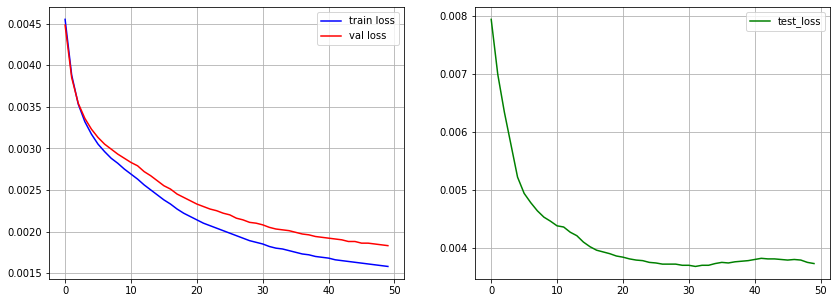

CPU times: user 5h 15min 10s, sys: 23min 37s, total: 5h 38min 47s
Wall time: 1h 35min 36s


In [16]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

Epoch 100
Train loss:	 0.00114
Val loss:	 0.00134
Test loss:	 0.00327


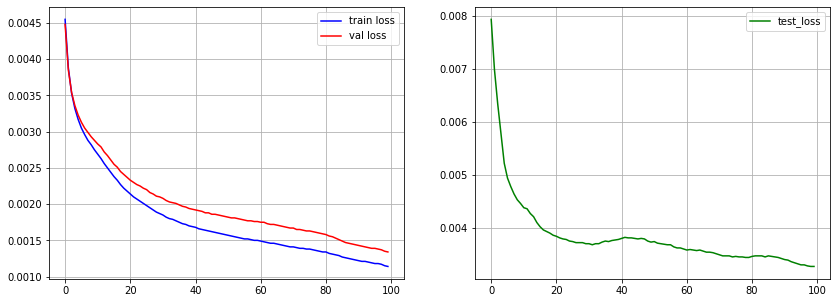

CPU times: user 5h 13min 6s, sys: 29min 54s, total: 5h 43min
Wall time: 1h 32min 2s


In [17]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [18]:
def get_prediction_errors(teacher, student, data):
    teacher.eval()
    student.eval()
    loss = []
    for images, _ in tqdm(data):
        with torch.no_grad():
            # Transfering images and labels to GPU if available
            images = images.to(device)
            images = images.view(-1, 1, 28, 28)
            # Forward pass
            teacher_pred = teacher(images)
            student_pred = student(images)
            loss.append(reverse_kl(teacher_pred, student_pred).item())
    return loss

In [19]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))

In [20]:
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.8804772709722223

Epoch 150
Train loss:	 0.00086
Val loss:	 0.001
Test loss:	 0.00233


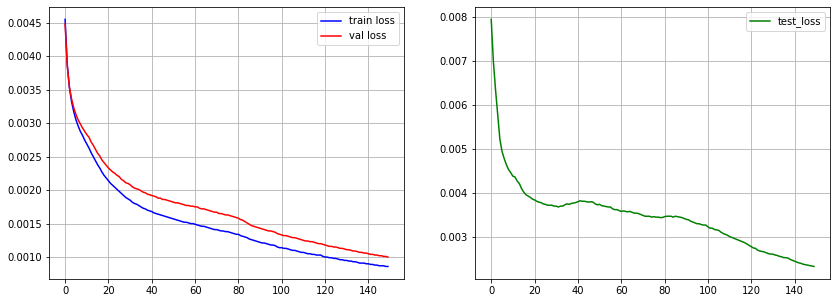

CPU times: user 5h 20min 43s, sys: 25min 7s, total: 5h 45min 50s
Wall time: 1h 33min 47s


In [21]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [22]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.8616962958333334

Epoch 200
Train loss:	 0.00073
Val loss:	 0.00085
Test loss:	 0.00175


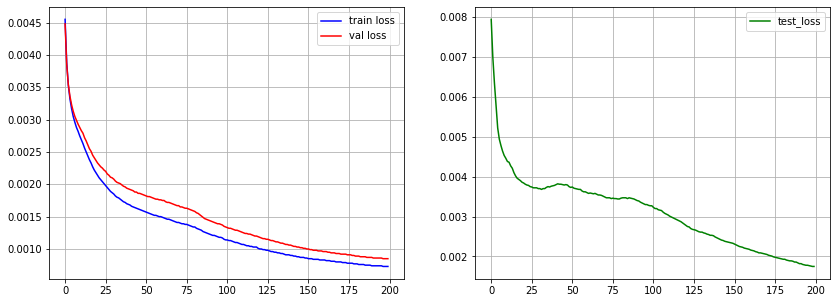

CPU times: user 4h 49min 37s, sys: 23min 4s, total: 5h 12min 42s
Wall time: 1h 40min 8s


In [23]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [24]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.8397713565277778

Epoch 250
Train loss:	 0.0006
Val loss:	 0.00071
Test loss:	 0.00142


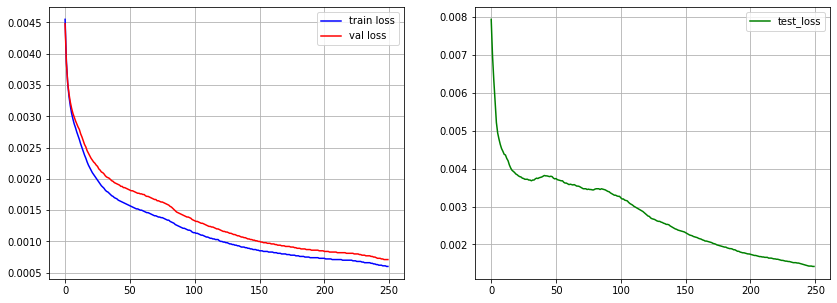

CPU times: user 3h 48min 24s, sys: 22min 14s, total: 4h 10min 39s
Wall time: 1h 44min 6s


In [25]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [26]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.8294617597222222

Epoch 300
Train loss:	 0.00055
Val loss:	 0.00065
Test loss:	 0.00136


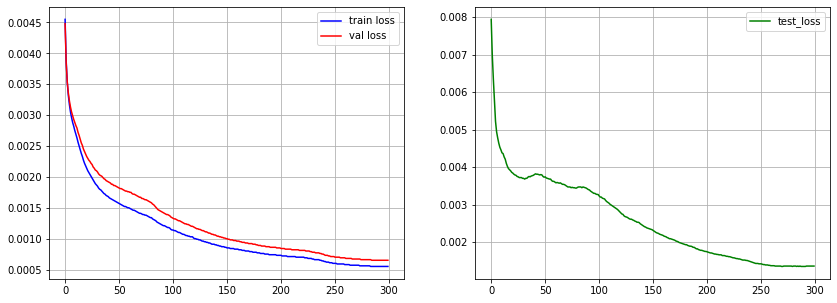

CPU times: user 3h 45min 18s, sys: 21min 40s, total: 4h 6min 58s
Wall time: 1h 48min 35s


In [27]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [28]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.8330949038888888

Epoch 350
Train loss:	 0.00053
Val loss:	 0.00063
Test loss:	 0.00139


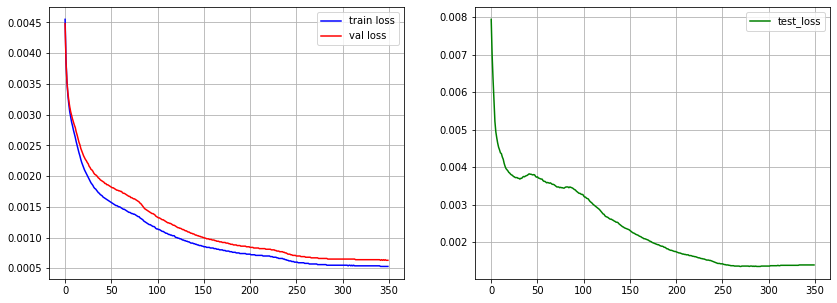

CPU times: user 3h 43min 35s, sys: 21min 55s, total: 4h 5min 31s
Wall time: 1h 41min 49s


In [29]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [30]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.841717255138889

Epoch 400
Train loss:	 0.00052
Val loss:	 0.00062
Test loss:	 0.0014


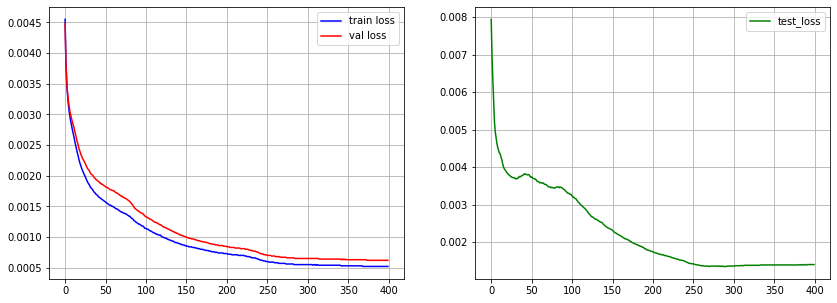

CPU times: user 3h 42min 45s, sys: 21min 42s, total: 4h 4min 27s
Wall time: 1h 41min 28s


In [31]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [32]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.8463438788888888

Epoch 450
Train loss:	 0.00051
Val loss:	 0.00061
Test loss:	 0.0014


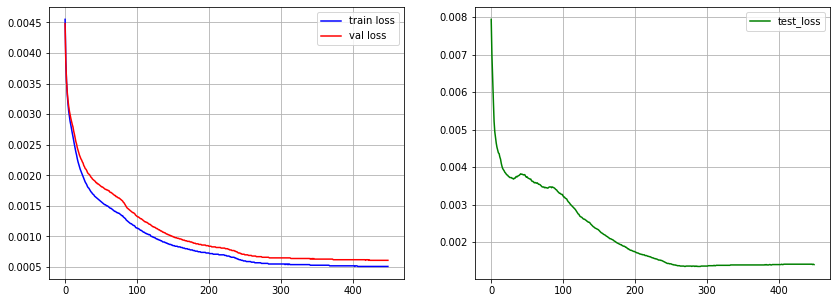

CPU times: user 5h 19min 54s, sys: 22min 49s, total: 5h 42min 44s
Wall time: 1h 34min 6s


In [33]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [34]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.8497979995833334

Epoch 500
Train loss:	 0.00051
Val loss:	 0.00061
Test loss:	 0.0014


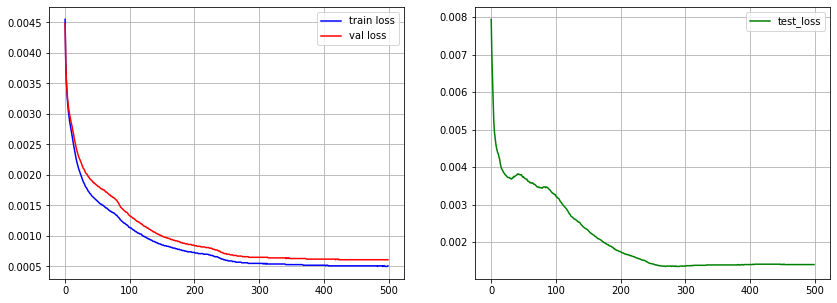

CPU times: user 5h 15min 53s, sys: 23min 38s, total: 5h 39min 32s
Wall time: 1h 35min 21s


In [35]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [36]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.8520292623611112

#### saving the figure

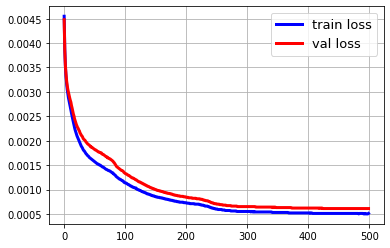

In [46]:
plt.plot(train_log, label='train loss', c='b', linewidth=3)
plt.plot(val_log, label='val loss', c='r', linewidth=3)
plt.grid()
plt.legend(loc='best', fontsize=13)
plt.savefig('learning_curves_train_original_to_fashion.pdf')

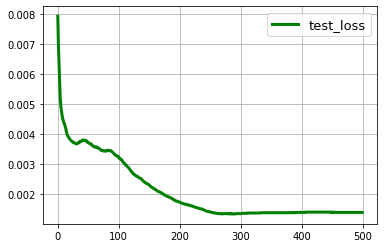

In [47]:
plt.plot(test_log, label='test_loss', c='g', linewidth=3)
plt.legend(loc='best', fontsize=13)
plt.grid()
plt.savefig('learning_curves_test_original_to_fashion.pdf')